# Models Comparison for TinyML

In [46]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import m2cgen as m2c
from micromlgen import port

import warnings
import seaborn as sbs

warnings.filterwarnings('ignore')

In [47]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [48]:
with open('../data/X_paper.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y_paper.pkl', 'rb') as f:
    y = pickle.load(f)

In [49]:
X = np.concatenate((X[:250], X[750:1000], X[1500:]), axis=0)
y = np.concatenate((y[:250], y[750:1000], y[1500:]), axis=0)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [51]:
print(np.unique(y))

[0 1 2 3 4 5 6]


## Model Spotting

In [52]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [53]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [54]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,39 0,03
LR - 0,34 0,03
CART - 0,67 0,02
SVC - 0,64 0,04
RF - 0,66 0,04


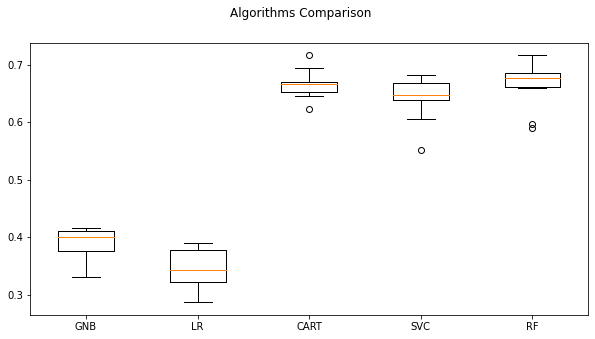

In [55]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Valutazione Inferance Rate medio (|X_test| = 100)

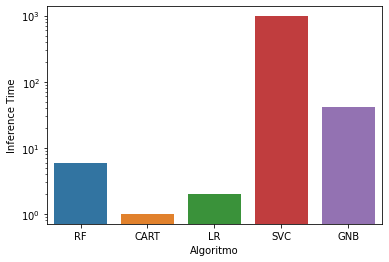

In [56]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

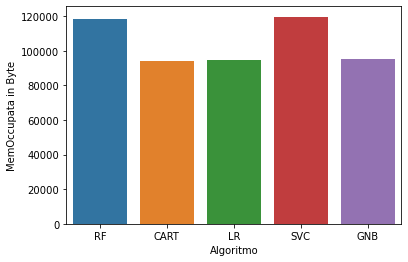

In [57]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [58]:
n = 100
model = Sequential(name="Sequential-NN")
model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
model.add(layers.Dense(np.unique(y).size, activation='softmax'))
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Convert to array[int]
y_train = np.array([int(num) for num in y_train])
y_test = np.array([int(num) for num in y_test])

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_40 (Dense)             (None, 700)               4200      
_________________________________________________________________
dense_41 (Dense)             (None, 7)                 4907      
Total params: 9,137
Trainable params: 9,137
Non-trainable params: 0
_________________________________________________________________


# Train and Test

In [45]:
EPOCHS = 750
BATCH_SIZE = 5

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test, pred))

Epoch 1/750
162/162 [==============================] - 0s 1ms/step - loss: 6.3469 - accuracy: 0.2593 - val_loss: 8.2909 - val_accuracy: 0.2593
Epoch 2/750
162/162 [==============================] - 0s 719us/step - loss: 5.6399 - accuracy: 0.2667 - val_loss: 3.9930 - val_accuracy: 0.2630
Epoch 3/750
162/162 [==============================] - 0s 642us/step - loss: 5.2621 - accuracy: 0.2704 - val_loss: 4.0758 - val_accuracy: 0.2778
Epoch 4/750
162/162 [==============================] - 0s 643us/step - loss: 4.0572 - accuracy: 0.2901 - val_loss: 4.9368 - val_accuracy: 0.1926
Epoch 5/750
162/162 [==============================] - 0s 623us/step - loss: 3.5709 - accuracy: 0.3309 - val_loss: 3.5056 - val_accuracy: 0.3222
Epoch 6/750
162/162 [==============================] - 0s 623us/step - loss: 4.0241 - accuracy: 0.3025 - val_loss: 6.4614 - val_accuracy: 0.3148
Epoch 7/750
162/162 [==============================] - 0s 741us/step - loss: 4.0560 - accuracy: 0.2901 - val_loss: 3.0759 - val_accu

162/162 [==============================] - 0s 638us/step - loss: 1.1598 - accuracy: 0.5346 - val_loss: 1.1635 - val_accuracy: 0.5000
Epoch 114/750
162/162 [==============================] - 0s 647us/step - loss: 1.1395 - accuracy: 0.5358 - val_loss: 1.2689 - val_accuracy: 0.4778
Epoch 115/750
162/162 [==============================] - 0s 643us/step - loss: 1.1627 - accuracy: 0.5074 - val_loss: 1.1654 - val_accuracy: 0.5556
Epoch 116/750
162/162 [==============================] - 0s 652us/step - loss: 1.1789 - accuracy: 0.5099 - val_loss: 1.2329 - val_accuracy: 0.4407
Epoch 117/750
162/162 [==============================] - 0s 623us/step - loss: 1.1505 - accuracy: 0.5457 - val_loss: 1.1621 - val_accuracy: 0.4741
Epoch 118/750
162/162 [==============================] - 0s 653us/step - loss: 1.1603 - accuracy: 0.5444 - val_loss: 1.1461 - val_accuracy: 0.5259
Epoch 119/750
162/162 [==============================] - 0s 645us/step - loss: 1.1569 - accuracy: 0.5247 - val_loss: 1.1852 - val_ac

Epoch 224/750
162/162 [==============================] - 0s 612us/step - loss: 1.1121 - accuracy: 0.5432 - val_loss: 1.1637 - val_accuracy: 0.5259
Epoch 225/750
162/162 [==============================] - 0s 664us/step - loss: 1.0818 - accuracy: 0.5728 - val_loss: 1.1055 - val_accuracy: 0.5407
Epoch 226/750
162/162 [==============================] - 0s 642us/step - loss: 1.0873 - accuracy: 0.5617 - val_loss: 1.0720 - val_accuracy: 0.5963
Epoch 227/750
162/162 [==============================] - 0s 640us/step - loss: 1.0859 - accuracy: 0.5395 - val_loss: 1.1225 - val_accuracy: 0.5963
Epoch 228/750
162/162 [==============================] - 0s 642us/step - loss: 1.0881 - accuracy: 0.5383 - val_loss: 1.0741 - val_accuracy: 0.5963
Epoch 229/750
162/162 [==============================] - 0s 642us/step - loss: 1.1009 - accuracy: 0.5519 - val_loss: 1.0727 - val_accuracy: 0.5778
Epoch 230/750
162/162 [==============================] - 0s 662us/step - loss: 1.0811 - accuracy: 0.5605 - val_loss: 1

Epoch 335/750
162/162 [==============================] - 0s 618us/step - loss: 1.0376 - accuracy: 0.5667 - val_loss: 1.0348 - val_accuracy: 0.6148
Epoch 336/750
162/162 [==============================] - 0s 663us/step - loss: 1.0466 - accuracy: 0.5617 - val_loss: 1.0377 - val_accuracy: 0.5704
Epoch 337/750
162/162 [==============================] - 0s 578us/step - loss: 1.0811 - accuracy: 0.5753 - val_loss: 1.1291 - val_accuracy: 0.5667
Epoch 338/750
162/162 [==============================] - 0s 613us/step - loss: 1.0525 - accuracy: 0.5716 - val_loss: 1.0313 - val_accuracy: 0.6111
Epoch 339/750
162/162 [==============================] - 0s 633us/step - loss: 1.0825 - accuracy: 0.5630 - val_loss: 1.0720 - val_accuracy: 0.5444
Epoch 340/750
162/162 [==============================] - 0s 642us/step - loss: 1.0736 - accuracy: 0.5568 - val_loss: 1.1000 - val_accuracy: 0.6111
Epoch 341/750
162/162 [==============================] - ETA: 0s - loss: 1.1172 - accuracy: 0.55 - 0s 585us/step - los

Epoch 446/750
162/162 [==============================] - 0s 642us/step - loss: 1.0392 - accuracy: 0.5716 - val_loss: 1.2398 - val_accuracy: 0.5037
Epoch 447/750
162/162 [==============================] - 0s 642us/step - loss: 1.0636 - accuracy: 0.5383 - val_loss: 1.0833 - val_accuracy: 0.5852
Epoch 448/750
162/162 [==============================] - 0s 592us/step - loss: 1.0268 - accuracy: 0.5877 - val_loss: 1.0519 - val_accuracy: 0.5778
Epoch 449/750
162/162 [==============================] - 0s 642us/step - loss: 1.0470 - accuracy: 0.5642 - val_loss: 1.0863 - val_accuracy: 0.5852
Epoch 450/750
162/162 [==============================] - 0s 592us/step - loss: 1.0191 - accuracy: 0.5765 - val_loss: 1.0351 - val_accuracy: 0.6296
Epoch 451/750
162/162 [==============================] - 0s 592us/step - loss: 1.0588 - accuracy: 0.5642 - val_loss: 1.0771 - val_accuracy: 0.5963
Epoch 452/750
162/162 [==============================] - 0s 642us/step - loss: 1.0335 - accuracy: 0.5840 - val_loss: 1

Epoch 502/750
162/162 [==============================] - 0s 642us/step - loss: 1.0322 - accuracy: 0.5840 - val_loss: 1.0352 - val_accuracy: 0.5407
Epoch 503/750
162/162 [==============================] - 0s 642us/step - loss: 1.0113 - accuracy: 0.5790 - val_loss: 1.0078 - val_accuracy: 0.6370
Epoch 504/750
162/162 [==============================] - 0s 642us/step - loss: 1.0164 - accuracy: 0.5691 - val_loss: 1.0370 - val_accuracy: 0.6000
Epoch 505/750
162/162 [==============================] - 0s 661us/step - loss: 1.0347 - accuracy: 0.5568 - val_loss: 1.2359 - val_accuracy: 0.5370
Epoch 506/750
162/162 [==============================] - 0s 764us/step - loss: 1.0426 - accuracy: 0.5667 - val_loss: 1.0243 - val_accuracy: 0.6185
Epoch 507/750
162/162 [==============================] - 0s 638us/step - loss: 1.0300 - accuracy: 0.5679 - val_loss: 1.0804 - val_accuracy: 0.5296
Epoch 508/750
162/162 [==============================] - 0s 740us/step - loss: 1.0222 - accuracy: 0.5765 - val_loss: 1

Epoch 558/750
162/162 [==============================] - 0s 691us/step - loss: 1.0481 - accuracy: 0.5654 - val_loss: 1.0720 - val_accuracy: 0.5667
Epoch 559/750
162/162 [==============================] - 0s 695us/step - loss: 1.0439 - accuracy: 0.5667 - val_loss: 1.0486 - val_accuracy: 0.5926
Epoch 560/750
162/162 [==============================] - 0s 689us/step - loss: 1.0263 - accuracy: 0.5815 - val_loss: 1.0185 - val_accuracy: 0.5741
Epoch 561/750
162/162 [==============================] - 0s 691us/step - loss: 1.0294 - accuracy: 0.5889 - val_loss: 1.0185 - val_accuracy: 0.6148
Epoch 562/750
162/162 [==============================] - 0s 691us/step - loss: 1.0054 - accuracy: 0.5901 - val_loss: 0.9953 - val_accuracy: 0.5741
Epoch 563/750
162/162 [==============================] - 0s 691us/step - loss: 1.0421 - accuracy: 0.5617 - val_loss: 1.1219 - val_accuracy: 0.5593
Epoch 564/750
162/162 [==============================] - 0s 609us/step - loss: 1.0279 - accuracy: 0.5778 - val_loss: 1

Epoch 614/750
162/162 [==============================] - 0s 658us/step - loss: 1.0470 - accuracy: 0.5654 - val_loss: 1.1731 - val_accuracy: 0.6000
Epoch 615/750
162/162 [==============================] - 0s 622us/step - loss: 1.0533 - accuracy: 0.5778 - val_loss: 1.1006 - val_accuracy: 0.5222
Epoch 616/750
162/162 [==============================] - 0s 630us/step - loss: 1.0424 - accuracy: 0.5617 - val_loss: 1.0184 - val_accuracy: 0.5963
Epoch 617/750
162/162 [==============================] - 0s 628us/step - loss: 1.0129 - accuracy: 0.5790 - val_loss: 1.0561 - val_accuracy: 0.5926
Epoch 618/750
162/162 [==============================] - 0s 645us/step - loss: 1.0388 - accuracy: 0.5617 - val_loss: 1.0474 - val_accuracy: 0.6074
Epoch 619/750
162/162 [==============================] - 0s 672us/step - loss: 1.0286 - accuracy: 0.5827 - val_loss: 0.9923 - val_accuracy: 0.6222
Epoch 620/750
162/162 [==============================] - 0s 642us/step - loss: 1.0143 - accuracy: 0.5815 - val_loss: 1

Epoch 670/750
162/162 [==============================] - 0s 631us/step - loss: 1.0489 - accuracy: 0.5889 - val_loss: 1.0077 - val_accuracy: 0.6333
Epoch 671/750
162/162 [==============================] - 0s 581us/step - loss: 0.9981 - accuracy: 0.6074 - val_loss: 1.0217 - val_accuracy: 0.6111
Epoch 672/750
162/162 [==============================] - 0s 627us/step - loss: 1.0218 - accuracy: 0.5753 - val_loss: 1.1739 - val_accuracy: 0.5111
Epoch 673/750
162/162 [==============================] - 0s 620us/step - loss: 1.0057 - accuracy: 0.5926 - val_loss: 1.0308 - val_accuracy: 0.5630
Epoch 674/750
162/162 [==============================] - 0s 632us/step - loss: 1.0111 - accuracy: 0.5815 - val_loss: 1.0486 - val_accuracy: 0.5815
Epoch 675/750
162/162 [==============================] - 0s 630us/step - loss: 1.0292 - accuracy: 0.5802 - val_loss: 1.0212 - val_accuracy: 0.6296
Epoch 676/750
162/162 [==============================] - 0s 614us/step - loss: 1.0099 - accuracy: 0.5938 - val_loss: 1

Epoch 726/750
162/162 [==============================] - 0s 640us/step - loss: 1.0112 - accuracy: 0.5938 - val_loss: 0.9795 - val_accuracy: 0.6074
Epoch 727/750
162/162 [==============================] - 0s 773us/step - loss: 0.9791 - accuracy: 0.5951 - val_loss: 1.0009 - val_accuracy: 0.5852
Epoch 728/750
162/162 [==============================] - 0s 742us/step - loss: 0.9980 - accuracy: 0.5827 - val_loss: 1.1036 - val_accuracy: 0.6037
Epoch 729/750
162/162 [==============================] - 0s 661us/step - loss: 1.0504 - accuracy: 0.5580 - val_loss: 1.1296 - val_accuracy: 0.5481
Epoch 730/750
162/162 [==============================] - 0s 722us/step - loss: 1.0329 - accuracy: 0.5778 - val_loss: 1.0640 - val_accuracy: 0.5593
Epoch 731/750
162/162 [==============================] - 0s 692us/step - loss: 1.0372 - accuracy: 0.5827 - val_loss: 0.9820 - val_accuracy: 0.5889
Epoch 732/750
162/162 [==============================] - 0s 672us/step - loss: 0.9799 - accuracy: 0.6086 - val_loss: 1

# Export Models in C code

In [76]:
# Models in Pipeline
modelsInPipeline = []
modelsInPipeline.append('LR')

In [77]:
for name, model in models:
    prepath = 'exportedModels/'
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))